In [1]:
from tree_partition import sample_uniform_partition_of_tree
import matplotlib.pyplot as plt
import tree_utils as tu
import networkx as nx
from tqdm import tqdm
import pandas as pd
import numpy as np
import math

In [182]:
def make_clique(n):
    return nx.complete_graph(n)

def make_biclique(n, m):
    return nx.complete_bipartite_graph(n, m)

def num_trees_clique(n):
    return n ** (n-2)

def num_snappables_clique(n):
    assert n % 2 == 0
    combo = math.comb(n, int(n/2))
    return combo * (2 / (2 ** n)) * (n ** (n - 2))

def fraction_nears_clique(n, eps):
    first_combo = math.comb(n, int(0.5 * (1 - eps) * n)) # flooring denominator
    second_combo = math.comb(int(0.5 * (1 + eps) * n), int(0.5 * (1 - eps) * n)) # flooring both
    term_1 = eps ** (eps * n)
    term_2 = (1 - eps) ** ((n * (1 - eps)) - 2)
    term_3 = 2 ** (n * (eps - 1))
    return 4 * first_combo * second_combo * term_1 * term_2 * term_3

def fraction_snappables_clique(n):
    return num_snappables_clique(n) / num_trees_clique(n)

def num_trees_biclique(m, n):
    return (m ** (n - 1)) * (n ** (m - 1))

def num_snappables_equal_biclique(n):
    result = 0
    for k in range(1, n): # 1 to n - 1, inclusive
        combo = math.comb(n, k) ** 2
        num_pairs_trees = ((k ** (n - k - 1)) * ((n - k) ** (k - 1))) ** 2
        num_cross_edges = (k ** 2) + ((n - k) ** 2)
        result += (combo * num_pairs_trees * num_cross_edges)
    return 0.5 * result

def num_snappables_multiplier_biclique(n, m):
    c = (2 * m) + 1
    result = 0
    for k in range(1, n): # 1 to n - 1, inclusive
        a1 = math.comb(n, k)
        a2 = math.comb(n * c, (n * (m + 1)) - k)
        b1 = k ** ((n * (m + 1)) - k - 1)
        b2 = (n * (m + 1) - k) ** (k - 1)
        b3 = (n - k) ** ((n * m) + k - 1)
        b4 = ((n * m) + k) ** (n - k - 1)
        c1 = (k * ((n * m) + k)) + ((n - k) * (n * (m + 1) - k))
        result += (a1 * a2 * b1 * b2 * b3 * b4 * c1)
    return 0.5 * result
        

def fraction_snappables_equal_biclique(n):
    return num_snappables_equal_biclique(n) / num_trees_biclique(n, n)

def fraction_snappables_multiplier_biclique(n, m):
    c = (2 * m) + 1
    return num_snappables_multiplier_biclique(n, m) / num_trees_biclique(n, c*n)

def sum_terms(n, k):
    nterm_1 = k ** ((2 * n) - (4 * k) - 3)
    nterm_2 = (n ** 2) + (2 * (k ** 2)) - (2 * n * k)
    dterm_1 = (n - k) ** ((2 * n) - (4 * k) + 3)
    return (nterm_1 * nterm_2) / dterm_1

def count_snaps(graph, trials, eps=0, viz=True):
    num_snaps = 0
    iterable = tqdm(range(trials)) if viz else range(trials)
    for _ in iterable:
        tree = tu.uniform_random_spanning_tree(graph)
        for node in tree.nodes:
            tree.nodes[node]['pop'] = 1
        min_part_size = (len(tree) * (1 - eps)) / 2
        max_part_size = (len(tree) * (1 + eps)) / 2
        _, num_balance_edges = sample_uniform_partition_of_tree(tree, 2, min_part_size, max_part_size, "pop")
        if num_balance_edges:
            num_snaps += 1
    return num_snaps / trials

In [164]:
%%time
num_trials = 10000
ms = [0, 1, 2]
Ns = [12, 24, 48, 96, 192, 384]

data = {}
for m in ms:
    graph_sizes = []
    proportions = []
    for N in Ns:
        assert N % (2 * (m + 1)) == 0
        n = int(N / (2 * (m + 1)))
        c = (2 * m) + 1
        graph = make_biclique(n, c * n)
        proportion = count_snaps(graph, num_trials)
        graph_sizes.append(len(graph))
        proportions.append(proportion)
    data[m] = (graph_sizes, proportions)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:30<00:00, 111.04it/s]

CPU times: user 7min 47s, sys: 7.09 s, total: 7min 54s
Wall time: 7min 59s


OverflowError: int too large to convert to float

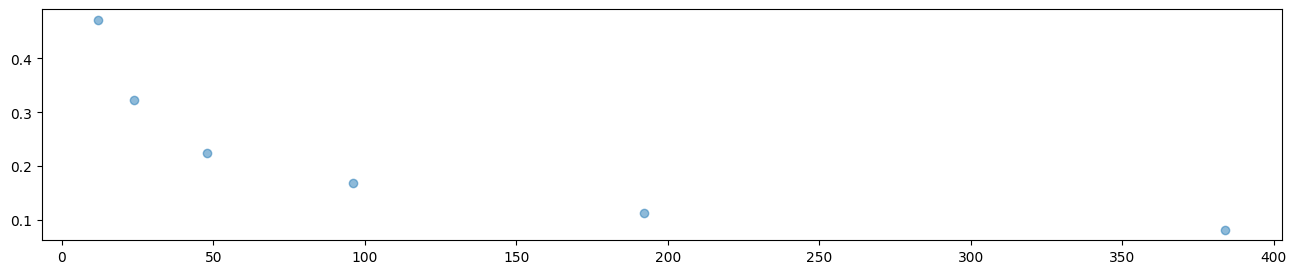

In [193]:
fig, ax = plt.subplots(figsize=(16,3))

C = math.sqrt(8 / math.pi)

for m in ms[:1]: 
    c = (2 * m) + 1
    plt.scatter(x=data[m][0],
                y=data[m][1],
                alpha=0.5,
                label=f"m={m}",
               )
    plt.scatter(x=data[m][0],
                y=[fraction_snappables_multiplier_biclique(n,m) for n in data[m][0]],
                marker='x',
                alpha=0.5,
                label=f"exact m={m}",
               )
    
# plt.plot(data[0][0],
#          [C / math.sqrt(n) for n in data[0][0]],
#          marker='o',
#          mfc='white',
#          ms=10,
#          alpha=0.5,
#          color='black',
#          label="C/sqrt{n}",
#         )

# plt.plot(data[0][0],
#          [C / math.sqrt(2 * n) for n in data[0][0]],
#          marker='o',
#          mfc='white',
#          ms=10,
#          alpha=0.5,
#          color='black',
#          label="C/sqrt{2 * n}",
#         )

plt.legend()
# plt.yscale('log')
# plt.xscale('log')

In [78]:
n = 10
m = 0
num_snappables_multiplier_biclique(n, m)

3.555031464685558e+17

In [79]:
num_snappables_equal_biclique(n)

3.555031464685558e+17

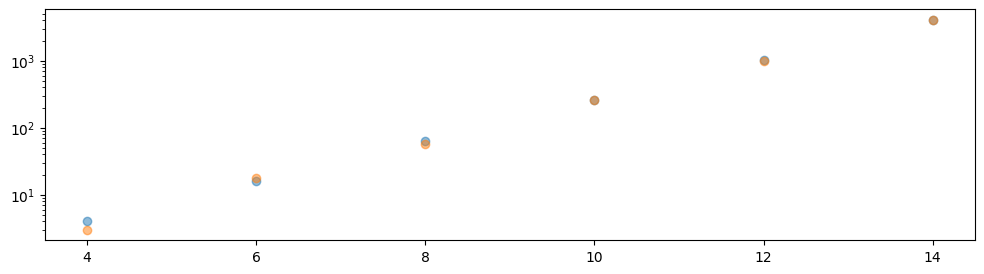

In [50]:
ns = [n for n in range(4, 16, 2)]
guess = [2 ** (n-2) for n in ns]
actual = [num_snappables_clique(n) / num_snappables_equal_biclique(int(n/2)) for n in ns]

fig, ax = plt.subplots(figsize=(12,3))
plt.scatter(x=ns,
            y=guess,
            alpha=0.5,
           )
plt.scatter(x=ns,
            y=actual,
            alpha=0.5,
           )
plt.yscale('log')

1.618451619662074e-05


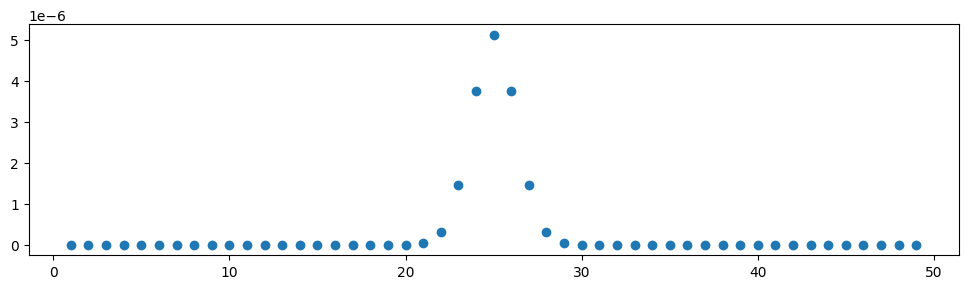

In [328]:
n = 50
values = [sum_terms(n, k) for k in range(1, n)]

fig, ax = plt.subplots(figsize=(12,3))
plt.scatter(x=range(1,n),
            y=values,
           )
# plt.axvline(x=n/2)
print(sum(values))
plt.savefig("heuristics/plots/fn_50.png", dpi=300, bbox_inches='tight')

14.179630807244127

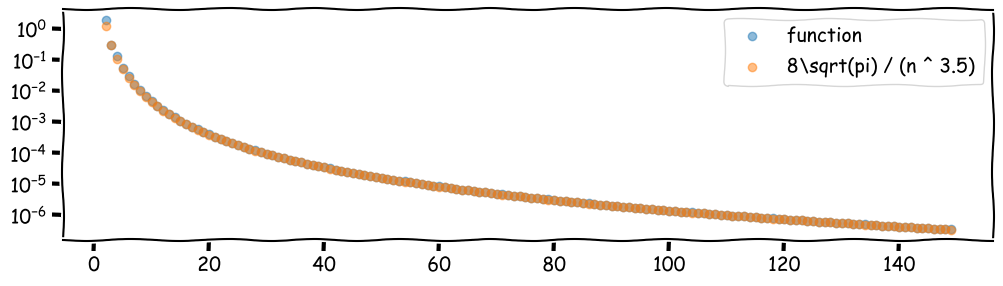

In [366]:
max_n = 150
sums = [sum([sum_terms(n, k) for k in range(1, n)]) for n in range(2, max_n)]

c = 8 * math.sqrt(math.pi)
guess = [c / (n ** 3.5) for n in range(2, max_n)]
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,3))
    plt.scatter(x=range(2,max_n),
                y=sums,
                alpha=0.5,
                label="function",
               )
    plt.scatter(x=range(2,max_n),
                y=guess,
                alpha=0.5,
                label="8\sqrt(pi) / (n ^ 3.5)",
               )
    plt.yscale('log')
    _ = plt.legend()
    # plt.savefig("heuristics/plots/checking_sum_asymptotics_wrong.png", dpi=300, bbox_inches='tight')

In [31]:
eps = 0.05
fraction_nears_clique(400, eps)

0.01652320982427978

In [179]:
def count_snaps(graph, trials, eps=0, viz=True):
    num_snaps = 0
    iterable = tqdm(range(trials)) if viz else range(trials)
    for _ in iterable:
        tree = tu.uniform_random_spanning_tree(graph)
        for node in tree.nodes:
            tree.nodes[node]['pop'] = 1
        min_part_size = (len(tree) * (1 - eps)) / 2
        max_part_size = (len(tree) * (1 + eps)) / 2
        _, num_balance_edges = sample_uniform_partition_of_tree(tree, 2, min_part_size, max_part_size, "pop")
        if num_balance_edges:
            num_snaps += 1
    return num_snaps / trials

In [185]:
N = 10
num_trials = 100000
graph = make_biclique(N, N)

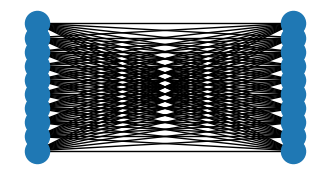

In [186]:
fig, ax = plt.subplots(figsize=(4,2))
left_set, right_set = nx.bipartite.sets(graph)

nx.draw(graph, pos=nx.bipartite_layout(graph, left_set), ax=ax)

In [187]:
proportion = count_snaps(graph, num_trials)

100%|█████████████████████████████████| 100000/100000 [01:02<00:00, 1611.16it/s]


In [188]:
proportion

0.35587

In [189]:
fraction_snappables_equal_biclique(N)

0.3555031464685558

In [101]:
# the above fractions should be basically equal!!! see the clique example below which is equal...

In [56]:
N = 200
eps = 0.01
num_trials = 10000
graph = make_clique(N)

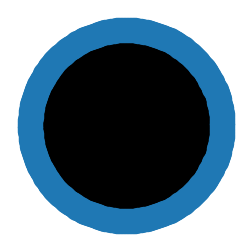

In [57]:
fig, ax = plt.subplots(figsize=(3,3))
nx.draw_circular(graph, ax=ax)

In [58]:
proportion = count_snaps(graph, num_trials, eps=eps)

100%|████████████████████████████████████| 10000/10000 [00:40<00:00, 249.63it/s]


In [ ]:
proportion

0.2375

In [ ]:
fraction_snappables_clique(N)

0.2507413752391585

In [165]:
%%time
epsilons = [0.5, 0.1, 0.001, 0.00001]
Ns = [4, 16, 128, 256, 1024]
num_trials = 10000

data = {}
for eps in epsilons:
    print(eps)
    fractions = []
    for N in Ns:
        graph = make_clique(N)
        fraction = count_snaps(graph, num_trials, eps=eps, viz=True)
        fractions.append(fraction)
    data[eps] = fractions

0.5


100%|█████████████████████████████████████| 10000/10000 [06:57<00:00, 23.96it/s]


0.1


100%|█████████████████████████████████████| 10000/10000 [06:06<00:00, 27.31it/s]


0.001


100%|█████████████████████████████████████| 10000/10000 [06:02<00:00, 27.61it/s]


1e-05


100%|█████████████████████████████████████| 10000/10000 [05:50<00:00, 28.54it/s]

CPU times: user 30min 20s, sys: 34.6 s, total: 30min 55s
Wall time: 31min


In [166]:
df = pd.DataFrame(data)
df.index = Ns

In [167]:
df

,0.50000,0.10000,0.00100,0.00001
4,0.7518,0.7547,0.7557,0.7556
16,0.9998,0.3989,0.3984,0.4030
128,1.0000,0.6714,0.1431,0.1417
256,1.0000,0.6709,0.0974,0.1025
1024,1.0000,0.7132,0.0501,0.0500


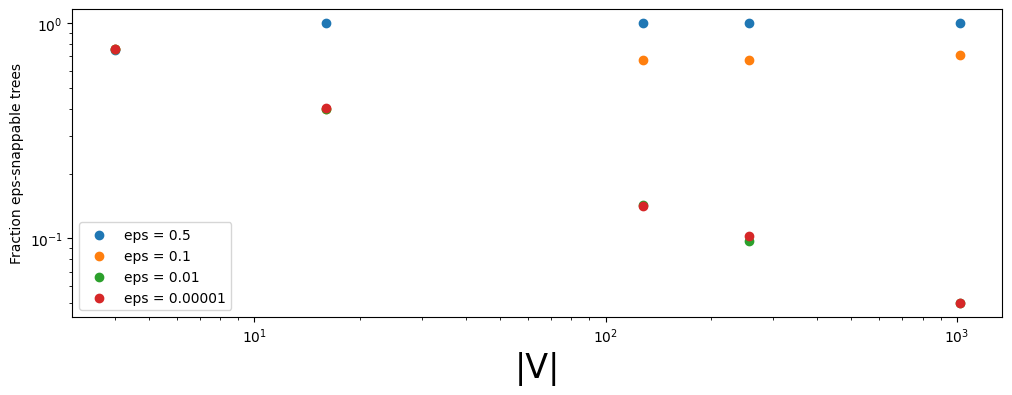

In [173]:
# with plt.xkcd():
fig, ax = plt.subplots(figsize=(12,4))
plt.scatter(df.index, df[0.5], label="eps = 0.5")
plt.scatter(df.index, df[0.10000], label="eps = 0.1")
plt.scatter(df.index, df[0.00100], label="eps = 0.01")
plt.scatter(df.index, df[0.00001], label="eps = 0.00001")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("|V|", fontsize=24)
plt.ylabel("Fraction eps-snappable trees")
_ = plt.legend()
plt.savefig("heuristics/plots/fraction_near_snappable.png", dpi=300, bbox_inches='tight')

In [170]:
tf = df.T
tf

,4,16,128,256,1024
0.50000,0.7518,0.9998,1.0000,1.0000,1.0000
0.10000,0.7547,0.3989,0.6714,0.6709,0.7132
0.00100,0.7557,0.3984,0.1431,0.0974,0.0501
0.00001,0.7556,0.4030,0.1417,0.1025,0.0500


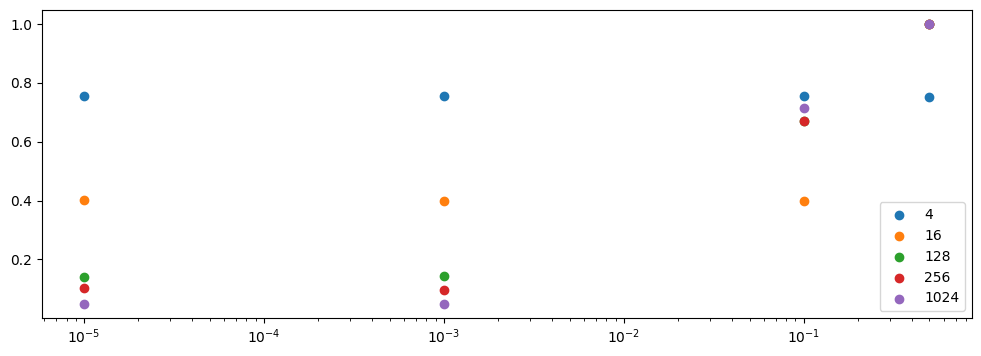

In [171]:
fig, ax = plt.subplots(figsize=(12,4))
tf = df.T

for N in Ns:
    plt.scatter(tf.index, tf[N], label=N)

plt.xscale("log")
_ = plt.legend()